## Use rasterio to load several geotiffs into specified coordinate window and calculate statistics


In [52]:
import json
import fiona
import numpy as np
import rasterio # rasterio and OGR don't mix...see rasterio docs
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
# list of files to read
fdir = "F:\\2017_Karen_Sandwich_maps\\"
fnames = (\
"2016-01-22_SandwichTNB_PT_DEM_10cm_trimmed.tif",\
"2016-01-25_SandwichTNB_DEM_10cm_trimmed.tif",\
"2016-02-11_SandwichTNB_DEM_10cm_trimmed.tif",\
"2016-03-30_SandwichTNB_AS_DEM_10cm_trimmed.tif",\
"2016-09-21_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-01-09_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-01-25_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-02-14_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-03-16_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-04-28_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-09-18_SandwichTNB_DEM_10cm_trimmed.tif"\
)
titles = ([\
         "22-Jan-2016",\
         "25-Jan-2016",\
         "11-Feb-2016",\
         "30-Mar-2016",\
         "21-Sep-2016",\
          "09-Jan-2017",\
          "25-Jan-2017",\
          "14-Feb-2017",\
          "16-Mar-2017",\
          "28-Apr-2017",\
          "09-Sep-2017"]
         )
print(fnames)
print(len(fnames))

('2016-01-22_SandwichTNB_PT_DEM_10cm_trimmed.tif', '2016-01-25_SandwichTNB_DEM_10cm_trimmed.tif', '2016-02-11_SandwichTNB_DEM_10cm_trimmed.tif', '2016-03-30_SandwichTNB_AS_DEM_10cm_trimmed.tif', '2016-09-21_SandwichTNB_DEM_10cm_trimmed.tif', '2017-01-09_SandwichTNB_DEM_10cm_trimmed.tif', '2017-01-25_SandwichTNB_DEM_10cm_trimmed.tif', '2017-02-14_SandwichTNB_DEM_10cm_trimmed.tif', '2017-03-16_SandwichTNB_DEM_10cm_trimmed.tif', '2017-04-28_SandwichTNB_DEM_10cm_trimmed.tif', '2017-09-18_SandwichTNB_DEM_10cm_trimmed.tif')
11


In [49]:
print(titles[1])

25-Jan-2016


Loading 11 files.
0
F:\2017_Karen_Sandwich_maps\2016-01-22_SandwichTNB_PT_DEM_10cm_trimmed.tif
xo,yo:  376286.64299908397 4625440.8344103005
xoff, yoff, xend, yend:  2013 10013 2408 9208
1
F:\2017_Karen_Sandwich_maps\2016-01-25_SandwichTNB_DEM_10cm_trimmed.tif
xo,yo:  376287.14850415837 4625434.75106331
xoff, yoff, xend, yend:  2008 10008 2347 9147
2
F:\2017_Karen_Sandwich_maps\2016-02-11_SandwichTNB_DEM_10cm_trimmed.tif
xo,yo:  376296.13149943855 4625448.832959766
xoff, yoff, xend, yend:  1918 9918 2488 9288
3
F:\2017_Karen_Sandwich_maps\2016-03-30_SandwichTNB_AS_DEM_10cm_trimmed.tif
xo,yo:  376292.3872081661 4625440.284709241
xoff, yoff, xend, yend:  1956 9956 2402 9202
4
F:\2017_Karen_Sandwich_maps\2016-09-21_SandwichTNB_DEM_10cm_trimmed.tif
xo,yo:  376232.5822683347 4625453.651816779
xoff, yoff, xend, yend:  2554 10554 2536 9336
5
F:\2017_Karen_Sandwich_maps\2017-01-09_SandwichTNB_DEM_10cm_trimmed.tif
xo,yo:  376323.5035454615 4625436.139639027
xoff, yoff, xend, yend:  1644 9644 23

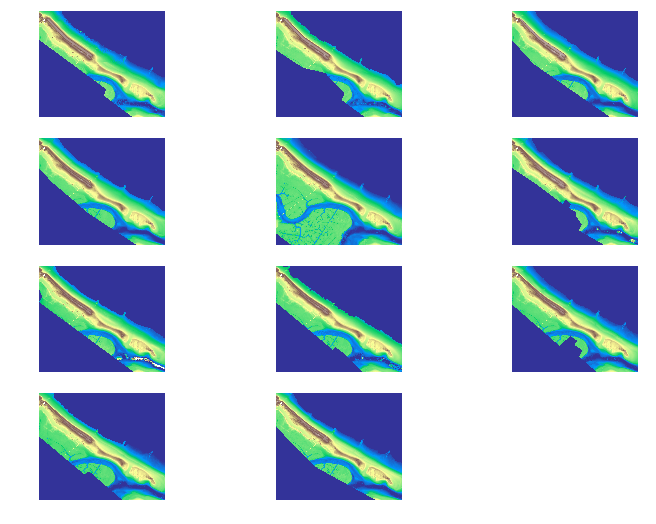

In [15]:
nf=len(fnames)
print("Loading {} files.".format(nf))

# top left corner of region of interest (UTM Zone 19N meters)
e0 = 376488.; n0 = 4625200.

# size of roi (colums, rows). divide by 10 to get meters
xsize, ysize = 8000, 6800

# initialize 3d array for data
zw = np.zeros((nf,ysize,xsize))

# declare a plot size
plt.subplots(figsize=(12,9))

# loop through the list of files
for i in range(nf):
    print(i)
    print(fdir+fnames[i])
    # open first time to determine origin
    with rasterio.open(fdir+fnames[i]) as src:
        # location of origin (upper left) from transform
        xo,yo = src.transform*(0,0)
        print('xo,yo: ',xo,yo)
        # index of first col, row in window from inverse transform
        xy = ~src.transform*(e0, n0)
        xoff, yoff = int(xy[0]), int(xy[1])
        print("xoff, yoff, xend, yend: ",xoff, xoff+xsize, yoff, yoff+ysize)
        src.close()
   
    # reopen and read band 1 (elevation...only band in these files) into specifed window
    with rasterio.open(fdir+fnames[i]) as src:
        # load into temporary 2d array
        # note the x,y switch: syntax for window=((row_start, row_stop)(col_start, col_stop)
        zt = src.read(1, window=((yoff,yoff+ysize),(xoff,xoff+xsize)))
        # copy 2d array into slab of 3d array
        zw[i::]=zt
       
        # small plots of elevation
        plt.subplot(4,3,i+1);plt.axis('off');plt.imshow(zt,cmap=plt.cm.terrain,vmin=-2,vmax=8)
        src.close()
        plt.savefig('time_series.png')

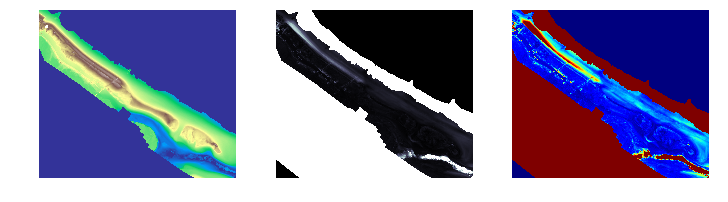

In [16]:
# Calculate mean and std. dev. of maps. Could do any numpy array statistics here, with or without NaNs
zmean = np.mean(zw,0)
zstd = np.std(zw,0)
zmin = np.min(zw,0)
zmax = np.max(zw,0)
zrange = zmax-zmin
plt.subplots(figsize=(12,6))
plt.subplot(1,3,1);plt.axis('off');plt.imshow(zmean[0::],cmap=plt.cm.terrain,vmin=-2,vmax=8)
plt.subplot(1,3,2);plt.axis('off');plt.imshow(zstd[0::],cmap=plt.cm.bone,vmin=0,vmax=2)
plt.subplot(1,3,3);plt.axis('off');plt.imshow(zrange[0::],cmap=plt.cm.jet,vmin=0,vmax=3)



In [54]:
# load a polygon I drew in Global Mapper and saved in geojson format
with open('std_crop_poly.geojson') as f:
    data = json.load(f)

for feature in data['features']:
    print(feature['geometry']['type'])
    #print(feature['geometry']['coordinates'])
    #print(feature['geometry'])

#print(" ")
jsonfeatures = data['features'][0]['geometry']
#print(jsonfeatures)

Polygon


In [ ]:
Use shapely to mask. See:
https://stackoverflow.com/questions/34825074/testing-point-with-in-out-of-a-vector-shapefile?noredirect=1&lq=1

In [17]:
# Use the last file to define the output coord. ref. system
# Note: in my laptop installation, using 'dtype': dtype(zstd) worked fine. On my desktop, I get type errors writing the file...
# because when I define dtype: 'float32', it is a mismatch with the array type.
print(src.crs)
print(src.transform)
profile = {'driver': 'GTiff', 'height': ysize, 'width': xsize, 'count': 1,\
           'dtype': 'float64', 'crs':src.crs, 'transform': src.transform}
print(profile)

CRS({'init': 'epsg:6348'})
| 0.10, 0.00, 376276.89|
| 0.00,-0.10, 4625437.52|
| 0.00, 0.00, 1.00|
{'driver': 'GTiff', 'height': 6800, 'width': 8000, 'count': 1, 'dtype': 'float64', 'crs': CRS({'init': 'epsg:6348'}), 'transform': Affine(0.09999999999999802, 0.0, 376276.8919304822,
       0.0, -0.1, 4625437.520928205)}


In [18]:
# write the tiff files
with rasterio.open('zmean.tif', 'w', **profile) as dst:
    dst.write(zmean, indexes=1)
    dst.close()
    
with rasterio.open('zstd.tif', 'w', **profile) as dst:
    dst.write(zstd, indexes=1)
    dst.close()
    
with rasterio.open('zrange.tif', 'w', **profile) as dst:
    dst.write(zrange, indexes=1)
    dst.close()

In [36]:
# calculate the anomaly (map minus mean)
zanomaly = np.zeros_like(zw)
for i in range(nf):
    zanomaly[i,:,:] = zmean - zw[i,:,:]
    

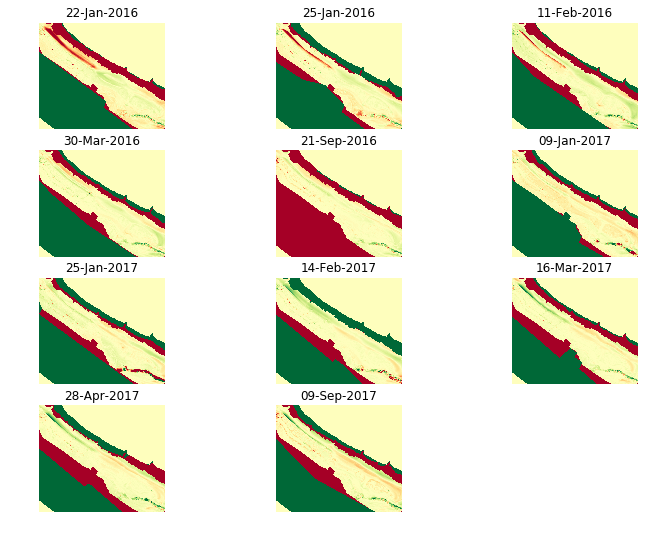

In [50]:
# plot the anomaly
# declare a plot size
plt.subplots(figsize=(12,9))
zimage = np.zeros((ysize,xsize))
for i in range(nf):
    zimage = np.squeeze(zanomaly[i,:,:])
    plt.subplot(4,3,i+1);plt.axis('off');plt.imshow(zimage,cmap=plt.cm.RdYlGn,vmin=-2,vmax=2)
    plt.title(titles[i])
    src.close()
    plt.savefig('anomaly.png')

In [6]:
# calculate total change (last minus first)
ztdif = zw[nf-1][:][:]-zw[0][:][:]
fname = titles[nf-1]+"_minus_"+titles[0]+".tif"
with rasterio.open(fname, 'w', **profile) as dst:
    dst.write(ztdif, indexes=1)
    dst.close()

# calculate array of differences
zdiff = np.zeros((nf-1,ysize,xsize))
zd = np.zeros((ysize,xsize))
for i in range(nf-1):
    zd = zw[i+1][:][:]-zw[i][:][:]
    zdiff[i][:][:]=zd
    fname = titles[i+1]+"_minus_"+titles[i]+".tif"
    with rasterio.open(fname, 'w', **profile) as dst:
        dst.write(zd, indexes=1)
        dst.close()


In [7]:
# just as a check: does the sum of the differences = diff of last - first?
zcheck = ztdif - np.sum(zdiff,0)
nmax = np.nanmax( zcheck )
print(nmax)

0.0
